In [166]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras

RANDOM_SEED = 42

In [167]:
# Para la compatibilidad de GPU y tensorflow uso
# tensorflow==2.10.1
# cuda = 11.2
# cudnn = 8.1.1
# python = 3.10.9
# https://www.tensorflow.org/install/source_windows?#gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print("GPUs Available: ", gpus)
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
      print(e)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Especificación de cada ruta

In [168]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
labels = 'model/keypoint_classifier/keypoint_classifier_label.csv'

# Configuración del número de clasificaciones

In [169]:
# Leer el contenido del archivo, eliminando el BOM si está presente
with open(labels, 'r', encoding='utf-8-sig') as f:
    content = f.read().splitlines()

# Convertir el contenido a un array de NumPy
labels_name = np.array(content, dtype=str)

print(labels_name)
NUM_CLASSES = len(labels_name)

['Open' 'Close' 'Pointer' 'mouse_up' 'mouse_down' 'mouse_left'
 'mouse_right' 'Ok' 'palma' 'mouse_diagonal_right_up'
 'mouse_diagonal_right_down' 'mouse_diagonal_left_up'
 'mouse_diagonal_left_down']


# Carga de datos de entrenamiento

In [170]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [171]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.60, random_state=RANDOM_SEED)

In [173]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=RANDOM_SEED)

# Construcción del modelo

In [174]:
from keras.regularizers import l2
model = keras.models.Sequential([
    keras.layers.Input((21 * 2, )),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [175]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_21 (Dropout)        (None, 42)                0         
                                                                 
 dense_28 (Dense)            (None, 64)                2752      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 16)                528       
                                                                 
 dense_31 (Dense)            (None, 13)               

In [176]:
# Callback de punto de control del modelo
cp_callback = keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback para detención temprana
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [177]:
# Compilación del modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo

In [178]:
# Entrenar el modelo y guardar la historia
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/20


575/581 [============================>.] - ETA: 0s - loss: 1.7318 - accuracy: 0.4322
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
581/581 [==============================] - 4s 6ms/step - loss: 1.7295 - accuracy: 0.4329 - val_loss: 1.0538 - val_accuracy: 0.7171
Epoch 2/20
579/581 [============================>.] - ETA: 0s - loss: 1.2647 - accuracy: 0.5907
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
581/581 [==============================] - 3s 6ms/step - loss: 1.2644 - accuracy: 0.5909 - val_loss: 0.8560 - val_accuracy: 0.7507
Epoch 3/20
578/581 [============================>.] - ETA: 0s - loss: 1.1344 - accuracy: 0.6395
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
581/581 [==============================] - 4s 7ms/step - loss: 1.1346 - accuracy: 0.6393 - val_loss: 0.7688 - val_accuracy: 0.7850
Epoch 4/20
576/581 [============================>.] - ETA: 0s - loss: 1.0600 - accuracy: 0.6710
Epo

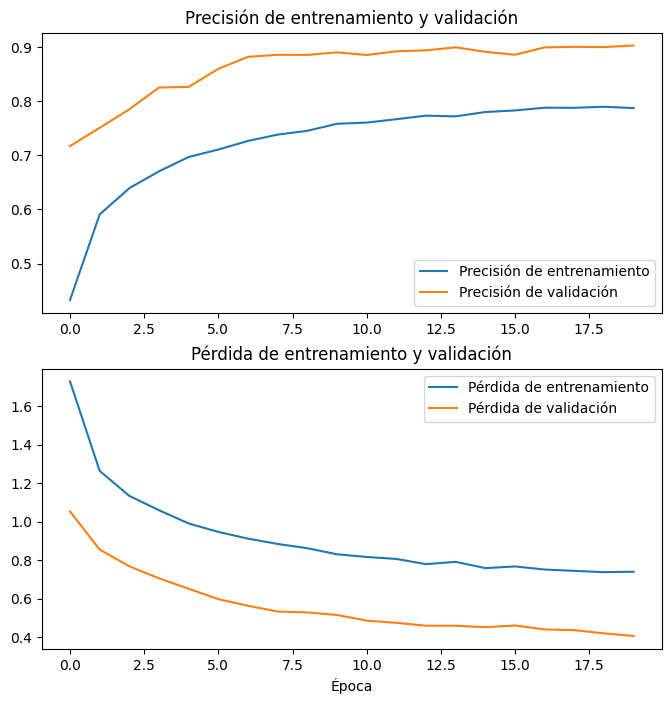

In [179]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y validación')

# Graficar la pérdida
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Época')
plt.show()

In [180]:
# Evaluación del modelo
val_loss, val_acc = model.evaluate(X_val, y_val, batch_size=128)

49/49 [==============================] - 0s 5ms/step - loss: 0.4181 - accuracy: 0.9025


In [181]:
# Carga del modelo guardado
model = tf.keras.models.load_model(model_save_path)

In [182]:
# Prueba de inferencia
predict_result = model.predict(np.array([X_val[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 57ms/step
[6.8140462e-02 1.1511351e-02 7.5622564e-03 4.5735789e-05 2.9744417e-03
 1.4451870e-08 8.2709007e-03 1.1074344e-05 9.0137184e-01 1.1149408e-04
 4.3096770e-07 5.2005271e-12 4.1402952e-08]
8


# Matriz de confusión

194/194 [==============================] - 1s 3ms/step


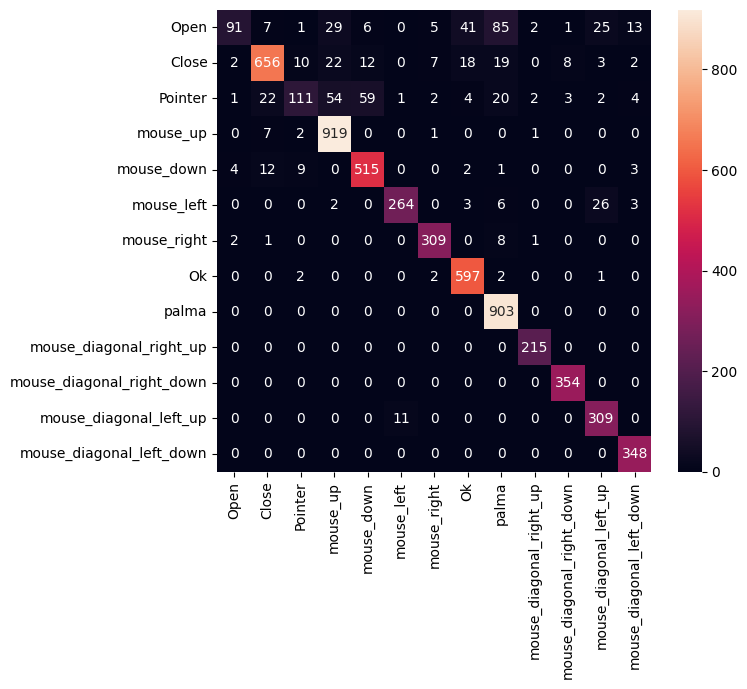

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.30      0.45       306
           1       0.93      0.86      0.90       759
           2       0.82      0.39      0.53       285
           3       0.90      0.99      0.94       930
           4       0.87      0.94      0.91       546
           5       0.96      0.87      0.91       304
           6       0.95      0.96      0.96       321
           7       0.90      0.99      0.94       604
           8       0.86      1.00      0.93       903
           9       0.97      1.00      0.99       215
          10       0.97      1.00      0.98       354
          11       0.84      0.97      0.90       320
          12       0.93      1.00      0.97       348

    accuracy                           0.90      6195
   macro avg       0.91      0.87      0.87      6195
weighted avg       0.90      0.90      0.89      6195



In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, labels_name, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=range(len(labels_name)))
    
    df_cmx = pd.DataFrame(cmx_data, index=labels_name, columns=labels_name)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_val, y_pred))

Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_val, y_pred, labels_name)

# Conversión a modelo para Tensorflow-Lite

In [184]:
# Guardar como modelo exclusivamente para inferencia
model.save(model_save_path, include_optimizer=False)

In [185]:
# Modelo de conversión (cuantificación)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\GAMA\AppData\Local\Temp\tmp3kj63s1t\assets


INFO:tensorflow:Assets written to: C:\Users\GAMA\AppData\Local\Temp\tmp3kj63s1t\assets


10824

# Prueba de inferencia

In [186]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [187]:
# Obtener tensores de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [188]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_val[0]]))

In [189]:
%%time
# Realizar inferencia
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [190]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.77792355e-02 1.12508135e-02 7.48820975e-03 4.62097378e-05
 2.95624882e-03 1.44995571e-08 8.04447103e-03 1.10906758e-05
 9.02313054e-01 1.10200010e-04 4.09470971e-07 5.19303524e-12
 4.18745572e-08]
8
